# Práctico 5: Taxi

Como se vio en clase, la idea detrás del aprendizaje por refuerzo es tan simple como atractiva:
aprender del ensayo y el error mediante la interacción con el entorno.

Cada vez que el agente, o el entrenador, realiza una acción en el entorno se proporciona una recompensa o una penalización.

La tarea del agente es aprender indirectamente, a partir de los refuerzos, a elegir la secuencia de acciones que producen mayor acumulación de refuerzo.


El objetivo principal de este notebook es demostrar, en un entorno simplificado, cómo se pueden utilizar las técnicas de aprendizaje por refuerzo para abordar un problema.

#### Vamos a utilizar el problema del taxi autonomo introducido por [Dietterich2000].

El problema conciste en recoger a un pasajero en un lugar y dejarlo en otro, ocupandose de lo siguiente:
 * Dejar al pasajero en la ubicación correcta.
 * Tomar el mínimo tiempo posible para dejar al pasajero.
 * Cuidar las normas de seguridad y tráfico.

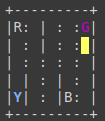

La figura muestra un entorno representado por una cuadrícula de 5 X 5, donde se encuentra el taxi (t). Hay cuatro espacios especialmente ubicados, marcados como R, B, G, Y. En cada episodio, el taxi comienza en un lugar elegido al azar. Hay un pasajero en uno de los cuatro lugares (elegido al azar), y ese pasajero desea ser transportado a una de las cuatro ubicaciones (también elegida al azar).
El taxi debe ir a la ubicación del pasajero, recojerlo, ir a la ubicación de destino, y dejar al pasajero allí.
El episodio finaliza cuando el pasajero es dejado en la ubicación de destino.

Hay seis **acciones** que puede tomar el agente en un estado dado:
    - (a) cuatro acciones de navegación que mueven el taxi: norte, sur, este u oeste
    - (b) dos acciones con los pasajeros: recogida y arribo


El agente recibe 20 puntos por una entrega exitosa y pierde 1 punto por cada paso a seguir. También hay una penalización de 10 puntos por acciones ilegales de recogida y arribo.





[Dietterich2000]	T Erez, Y Tassa, E Todorov, "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition", 2011.


# Aprendizaje por refuerzo

### Implementación:

Utilizaremos la biblioteca OpenAI Gym, la cuál ofrece diferentes entornos para probar un agente. La biblioteca se encarga de la API para proporcionar toda la información que requeriría el agente, como posibles acciones, recompenzas y estado actual. De esta forma solo necesitamos enfocarnos en la parte del algoritmo para el agente.

Primero instalamos gym, ejecutando la siguiente celda:

In [ ]:
# Una funcion de ayuda para imprimir el estado de nuestro mundo
def print_env(env):
  env_str = env.render()
  print(env_str)

Una vez instalado, podemos cargar el entorno y mostrarlo:

In [ ]:
from IPython.display import clear_output
from time import sleep
import numpy as np
import gymnasium as gym

seed = 1

env = gym.make("Taxi-v3", render_mode='ansi').env
env.reset(seed = seed)

print_env(env)

La interfaz principal de la biblioteca Gym es *env*.
Los siguientes son métodos útiles de *env*:
   * env.reset - Restablece el entorno y devuelve un estado inicial aleatorio.
   * env.step(acción) - Avanza el entorno por un paso de tiempo y retorna:
         - observation: observaciones del entorno
         - reward: si la acción fue beneficiosa o no
         - terminated: indica si recogió y dejó con éxito a un pasajero, también llamado 'episode'
         - truncated: si termino la ejecución por otros motivos (p.e. se ejecutaron más pasos que el límite) - no usado en este ejemplo
         - info: información adicional como el rendimiento y la latencia para fines de depuración - no usado en este ejemplo
   * env.render -  Renderiza una imagen del entorno, es útil para visualizar el entorno


Introduciendose más en el ambiente:

In [ ]:
env.reset(seed=seed) # restablece el entorno y devuelve un estado inicial aleatorio
print_env(env) # renderiza un cuadro

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))


Según lo verificado por las impresiones, tenemos un espacio de acción de tamaño 6 y un espacio de estado de tamaño 500:

25 plazas, 5 ubicación para el pasajero (contando las cuatro estaciones y el taxi) y los 4 destinos -> 25 x 5 x 4 = 500.

* El rectángulo de color representa el taxi,  amarillo es cuando va sin pasajero y verde con un pasajero.  
* '|' representa una pared que el taxi no puede cruzar.
* R, G, Y, B son las posibles ubicaciones de recogida y destino. La letra azul representa la ubicación actual de recogida de pasajeros, y la letra púrpura es el destino actual.


Se necesita  una forma de identificar un estado de manera única, esto se realiza mediante la asignación de un número único a cada estado posible, y el aprendizaje por refuerzos aprenderá a elegir un número de acción de 0-5 donde:

* 0 = sur
* 1 = norte
* 2 = este
* 3 = oeste
* 4 = pickup
* 5 = dropoff

El aprendizaje por refuerzo aprenderá el mapeo estado - acción óptimo, es decir, el agente explora el entorno y toma acciones basadas en las recompensas definidas en el entorno.

La acción óptima para cada estado es la acción que tiene la mayor recompensa acumulativa a largo plazo.

Recordar que el taxi se encuenetra en la fila 3, columna 1,  el pasajero está en la ubicación 2 y nuestro destino es la ubicación 0.


In [ ]:
starting_state, info = env.reset(seed = seed)
print_env(env)
print(starting_state)

### La tabla de recompensas

Cuando se crea el entorno,  se crea también una tabla de transiciones y recompensas inicial llamada **P**. Podemos pensar en ella como una matriz que tiene el número de estados como filas y el número de acciones como columnas.

Como cada estado está en esta matriz, podemos ver los valores de recompensa predeterminados asignados al estado:

In [ ]:
env.env.env.P[starting_state]

El diccionario tiene la estructura:

               acción: [(probabilidad, proximo estado, recompensa, done)]

Donde:
* 0-5 corresponde a las acciones que puede tomar el taxi en el estado actual.
* La probabilidad es siempre 1
* El siguiente estado es el estado en el que estaríamos si tomamos la acción en este índice del diccionario,
* Todas las acciones de movimiento tienen una recompensa de -1 y las acciones de recogida / devolución tienen una recompensa de -10 en este estado en particular. Si estamos en un estado donde el taxi tiene un pasajero y está en el destino correcto veríamos una recompensa de 20 en la acción de devolución (5).
* 'done' se usa para decirnos cuándo hemos dejado con éxito a un pasajero en la ubicación correcta. Cada entrega exitosa es el final de un episodio.




## Resolviendo el entorno sin aprendizaje por refuerzo

Veamos qué sucedería si tratamos de utilizar la fuerza bruta para resolver el problema.

Dado que tenemos nuestra tabla **P** para recompensas predeterminadas en cada estado, podemos intentar que nuestro taxi navegue solo utilizando esa información.

Crearemos un bucle que se ejecutará hasta que un pasajero llegue a un destino (un episodio), o en otras palabras, cuando la recompensa recibida sea 20.

El método *env.action_space.sample()* selecciona automáticamente una acción aleatoria del conjunto de todas las posibles acciones.

Veamos qué pasa:


In [ ]:
env.reset(seed = seed)

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation

terminated = False
truncated = False

while not terminated and not truncated:
    action = env.action_space.sample() #  selecciona una acción aleatoria del conjunto de todas las posibles acciones
    state, reward, terminated, truncated, info = env.step(action)

    if reward == -10:
        penalties += 1

    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1


print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))


In [ ]:
def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print('Timestep: ',i + 1)
        print('State: ',frame['state'])
        print('Action: ',frame['action'])
        print('Reward: ',frame['reward'])
        sleep(.01)

print_frames(frames)

Como se ve, para entregar solo un pasajero el agente le muchisimos pasos y realiza muchas devoluciones incorrectas. Esto se debe a que no estamos aprendiendo de la experiencia pasada. Podemos ejecutar esto una y otra vez, y nunca se optimizará, el agente no recuerda qué acción fue la mejor para cada estado, que es exactamente lo que el aprendizaje por refuerzo hará.


## Utilizando aprendizaje por refuerzo

Q-learning permite al agente usar las recompensas del entorno para aprender con el pasar del tiempo la mejor accion a tomar en un estado dado.

En el entorno del taxi tenemos la tabla de recompensas P de la que el agente aprenderá. Buscará recibir una recompensa por tomar una acción en el estado actual y luego actualizará el Q-value para recordar si esa acción fue beneficiosa.

Los valores almacenados en la tabla se denominan Q-values y se asignan a una combinación (estado, acción).

Un Q-value para una combinación particular de estado-acción es representativo de la "calidad" de una acción tomada en ese estado. Los mejores Q-values implican mejores posibilidades de obtener mayores recompensas.

Por ejemplo, si el taxi se enfrenta a un estado que incluye a un pasajero en su ubicación actual, es muy probable que el Q-values para la recogida sea más alto en comparación con otras acciones, como el descenso o el norte.

Los Q-values se inicializan a un valor arbitrario, y a medida que el agente se expone al entorno y recibe diferentes recompensas al ejecutar diferentes acciones, los Q-value se actualizan utilizando la ecuación:


$$ Q({\small state}, {\small action}) \leftarrow (1 - \alpha) Q({\small state}, {\small action}) + \alpha \Big({\small reward} + \gamma \max_{a} Q({\small next \ state}, {\small a})\Big)$$



donde:

- $\alpha$ es el learning rate $(0 < \alpha \le 1)$,  el grado en que los Q-values se actualizan en cada iteración.
- $\gamma$ es el factor de descuento $(0\le \gamma \le 1)$, determina cuánta importancia queremos dar a futuras recompensas. Un valor alto para el factor de descuento (cercano a 1) genera la adjudicación efectiva a largo plazo, mientras que un factor de descuento de 0 hace que nuestro agente considere solo una recompensa inmediata.

Se le asigna, o actualiza, el Q-value para un estado y  una acción primero tomando los pesos (1−α) de los viejos Q-value, y luego se le suma el resultado aprendido.

El valor aprendido es una combinación de la recompensa por tomar la acción actual en el estado actual y la recompensa máxima, con descuento, del siguiente estado en el que estaremos una vez que tomemos la acción actual.

Básicamente, estamos aprendiendo la acción adecuada para tomar en el estado actual al observar la recompensa para el par estado - acción actual, y las recompensas máximas para el siguiente estado. Esto eventualmente hará que nuestro taxi considere la ruta con las mejores recompensas.

El  Q-value de un par  estado-acción es la suma de la recompensa instantánea y la recompensa futura con descuento (del estado resultante). La forma en que almacenamos los  Q-value para cada estado y acción es a través de una
Q-table

La  Q-table es una matriz donde tenemos una fila para cada estado (500) y una columna para cada acción (6). Primero se inicializa a 0, y luego los valores se actualizan con el entrenamiento.

Tenga en cuenta que la Q-table tiene las mismas dimensiones que la tabla de recompensas, pero tiene un propósito completamente diferente.


## Resumiendo el proceso de Q-Learning

*  Inicializar la  Q-table con cero.
*  Comenzar explorando acciones: para cada estado, seleccionar una de todas las posibles acciones para el estado actual (S).
*  Cambiar al nuevo estado (S') como resultado de la acción (a).
*  Para cada acción posible desde el estado (S') seleccionar la que tenga el mayor Q-value.
*  Actualizar los valores de  Q-table utilizando la ecuación.
*  Setear el próximo estado como estado siguiente.
*  Si se alcanza el estado objetivo, luego se repite el proceso.

#### Aprovechar los valores aprendidos

Después de una exploración aleatoria de acciones los  Q-values tienden a converger sirviendo al agente como una función de valor-acción que puede aprovechar para elegir la mejor acción de un estado dado.

Existe una compensación entre la exploración (elegir una acción aleatoria) y la explotación (elegir acciones basadas en Q-values ya aprendidos). Queremos evitar que la acción tome siempre la misma ruta y posiblemente se sobreajuste, por lo que presentaremos otro parámetro llamado $\epsilon$

En lugar de simplemente seleccionar la mejor acción de Q-values, a veces favoreceremos explorar más el espacio de acción. Un valor más bajo de épsilon produce episodios con más penalizaciones (en promedio), lo cual es esperable porque estamos explorando y tomando decisiones aleatorias.




## Implementar Q-learning

### Entrenando el agente

Primero se inicializa con cero la Q-table a una matriz de 500 x 6.

In [ ]:
q_table = np.zeros([env.observation_space.n, env.action_space.n])

Ahora se crea el algoritmo de entrenamiento que actualizará esta Q-table mientras el agente explora el entorno durante muchos episodios.

En la primera parte de "while not done" se decide si se elige una acción aleatoria o aprovechar los Q-values ya calculados. Esto se hace simplemente usando el valor épsilon y comparándolo con la función random.uniform(0, 1), que devuelve un número arbitrario entre 0 y 1.

Ejecutamos la acción elegida en el entorno para obtener el siguiente estado (naxe_state) y la recompensa (reward) de realizar la acción. Después de eso, calculamos el valor Q-value para las acciones correspondientes a next_state, y con eso, podemos actualizar fácilmente nuestro Q-value a new_q_value.

In [ ]:
%%time
"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 0.95
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 10000):
    state, info = env.reset()
    epochs, penalties, reward, = 0, 0, 0
    terminated = False
    truncated = False
    while not terminated and not truncated:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, terminated, truncated, info = env.step(action)
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])

        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1

    if i % 100 == 0:
        clear_output(wait=True)
        print('Episode: ', i)

print("Training finished.\n")

In [ ]:
state, info = env.reset()

Ahora que la Q-table se ha establecido en más de 100,000 episodios, veamos cuáles son los Q-values en el estado de nuestra ilustración:

In [ ]:
q_table[starting_state]

## Evaluar al agente

Vamos a evaluar el desempeño del agente. No necesitamos explorar más acciones, por lo que ahora la siguiente acción siempre se selecciona utilizando el mejor Q-value:

In [ ]:
"""Evaluate agent's performance after Q-learning"""

total_epochs, total_penalties = 0, 0
episodes = 100

for _ in range(episodes):
    state, info = env.reset(seed = seed)
    epochs, penalties, reward = 0, 0, 0

    terminated = False
    truncated = False
    while not terminated and not truncated:
        action = np.argmax(q_table[state])
        state, reward, terminated, truncated, info = env.step(action)

        if reward == -10:
            penalties += 1

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print('Results after ',episodes, 'episodes:')
print('Average timesteps per episode: ',total_epochs / episodes)
print('Average penalties per episode: ',total_penalties / episodes)

## Hiperparámetros y  optimizaciones


Los valores de `alpha`, `gamma`, y `epsilon` estan basados en la intución y en algunos "hit and trial", pero hay mejores formas de encontrar buenos valores.

Idealmente los tres deberían disminuir con el tiempo dado que a medida que el agente continúa aprendiendo, en realidad acumula antecedentes más resistentes:
* $\alpha$ debería disminuir a medida que continua obteniendo una base de conocimiento cada vez mayor.
* $\gamma$ a medida que se acerque más y más al límite, su preferencia por la recompensa a corto plazo debería aumentar, ya que no estará lo suficientemente cerca como para obtener la recompensa a largo plazo, lo que significa que su gama debería disminuir.
* $\epsilon$ a medida que se desarrolla la estrategia, se tiene menos necesidad de exploración y más explotación para obtener más utilidad de la política, por lo que a medida que aumentan los ensayos, epsilon debería disminuir.


## Tuneando los  hiperparámetros

Modifique los hiperparametros analizando que significa cada uno y como varían los resultados

In [ ]:
%%time
"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 0.95
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 10001):
    state, info = env.reset()
    epochs, penalties, reward, = 0, 0, 0
    terminated = False
    truncated = False
    while not terminated and not truncated:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, terminated, truncated, info = env.step(action)

        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])

        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1

    if i % 100 == 0:
        clear_output(wait=True)
        print('Episode: ',i)

print("Training finished.\n")

In [ ]:
q_table[starting_state]